In [212]:
% matplotlib inline

In [213]:
import numpy as np
import pandas as pd
import shapefile
import shapely.geometry as sgeom
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cartopy.io.shapereader as shpreader
from PIL import Image
from collections import defaultdict
from descartes import PolygonPatch
from jenkspy import jenks_breaks
from matplotlib.colors import rgb2hex
from shapely.geometry import Polygon
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

In [214]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

In [262]:
def load_fold_results(i, frac=""):
  """
  Note that the conversion rate was calculated through the following website.
  https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm
  """
  fold_data = pd.read_csv("../data/fold_%d/test.csv" % i)
  mu = np.load("../data/fold_%d/mu.npy" % i)
  std = np.load("../data/fold_%d/std.npy" % i)
  true = np.load("../results/fold_%d%s/y_true.npy" % (i, frac))
  l8 = np.load("../results/fold_%d%s/y_pred_l8.npy" % (i, frac))
  s1 = np.load("../results/fold_%d%s/y_pred_s1.npy" % (i, frac))
  gbm = np.load("../results/fold_%d%s/y_pred_gbm.npy" % (i, frac))
  ridge = np.load("../results/fold_%d%s/y_pred_ridge.npy" % (i, frac))
  
  return pd.DataFrame({
    "id": fold_data["id"],
    "true": true * std + mu,
    "l8": l8 * std + mu,
    "s1": s1 * std + mu,
    "gbm": gbm * std + mu,
    "ridge": ridge * std + mu,
    "pred": np.average((l8 * std + mu, s1 * std + mu), axis=0, weights=[0.5, 0.5]),
    "state_idx": fold_data["state_idx"],
    "district_idx": fold_data["district_idx"],
    "taluk_idx": fold_data["taluk_idx"],
    "lat": fold_data["latitude"],
    "lng": fold_data["longitude"],
    "fold": i,
    "state_name": fold_data["state_name"],
    "district_name": fold_data["district_name"],
    "taluk_name": fold_data["taluk_name"]
  })

In [288]:
def convert_units(vector):
  return np.exp(vector) / 365.25 / 16.013

In [263]:
def smooth_preds(fold_df):
  knn = KNeighborsRegressor(n_neighbors=min(len(fold_df) // 2, 30))
  knn.fit(fold_df[["lat", "lng"]], fold_df["pred"])
  fold_df["smoothed"] = knn.predict(fold_df[["lat", "lng"]])
  return fold_df

In [264]:
def calculate_stats(fold_df):
  truth_z_score = (fold_df["true"] - np.mean(fold_df["true"])) / np.std(fold_df["true"])
  no_outliers = truth_z_score < 3
  return ({
    "count": len(fold_df),
    "pred_r2": r2_score(fold_df["true"], fold_df["smoothed"]),
    "pred_r2_no_outliers": r2_score(fold_df["true"][no_outliers], fold_df["smoothed"][no_outliers]),
    "outliers_frac": 1 - np.mean(no_outliers),
    "gbm_r2": r2_score(fold_df["true"], fold_df["gbm"]),
    "ridge_r2": r2_score(fold_df["true"], fold_df["ridge"]),
  })

In [265]:
def get_district_df(fold_df):
  district_df = fold_df.groupby("district_idx").mean().reset_index()
  return district_df[["district_idx", "true", "smoothed", "gbm", "ridge"]].rename(columns={"district_idx": "idx"})

def get_taluk_df(fold_df):
  taluk_df = fold_df.groupby("taluk_idx").mean().reset_index()
  return taluk_df[["taluk_idx", "true", "smoothed", "gbm", "ridge"]].rename(columns={"taluk_idx": "idx"})

In [299]:
def write_df(fold_df, idx):
  fold_df.to_csv("../results/fold_%d/test_results.csv" % idx)

In [300]:
fold_results = [load_fold_results(i) for i in range(1, 30)]
fold_results = list(map(smooth_preds, fold_results))

In [304]:
for i, fold in enumerate(fold_results):
  write_df(fold, i + 1)

In [268]:
india_df = pd.concat(fold_results)

In [316]:
india_df.to_csv("../results/india_df.csv")

In [269]:
calculate_stats(india_df)

{'count': 559721,
 'gbm_r2': 0.2172163597410398,
 'outliers_frac': 0.005495595126857822,
 'pred_r2': 0.268537341616092,
 'pred_r2_no_outliers': 0.2845929388698295,
 'ridge_r2': 0.1829481529609891}

In [283]:
taluk_df = get_taluk_df(india_df)
calculate_stats(taluk_df)

{'count': 2261,
 'gbm_r2': 0.4546555835879149,
 'outliers_frac': 0.0008845643520566382,
 'pred_r2': 0.4365983096995609,
 'pred_r2_no_outliers': 0.436615250076388,
 'ridge_r2': 0.38744942705124863}

In [284]:
district_df = get_district_df(india_df)
calculate_stats(district_df)

{'count': 650,
 'gbm_r2': 0.5165933198655372,
 'outliers_frac': 0.0,
 'pred_r2': 0.5162227550532277,
 'pred_r2_no_outliers': 0.5162227550532277,
 'ridge_r2': 0.46688066235975634}

In [272]:
def plot_vs_baseline(df):
  pctles = []
  r2s_smoothed = []
  r2s_gbm = []
  for pctle in np.arange(5, 101, 5):
    cutoff = np.percentile(df["true"], q=pctle)
    pctles.append(pctle)
    r2s_smoothed.append((df["true"][df["true"] < cutoff].corr(df["smoothed"][df["true"] < cutoff])) ** 2)
    r2s_gbm.append((df["true"][df["true"] < cutoff].corr(df["gbm"][df["true"] < cutoff])) ** 2)
  plt.plot(pctles, r2s_smoothed, label="Imagery / CNN + Smoothing")
  plt.plot(pctles, r2s_gbm, label="Night-lights / GBM")
  plt.xlabel("Percentile of poorest villages used")
  plt.ylabel("$r^2$")
  plt.legend()

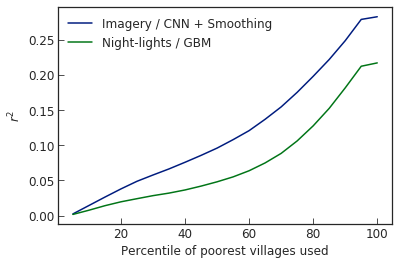

In [273]:
plot_vs_baseline(india_df)

In [289]:
def plot_scatters(district_df, taluk_df):

  plt.figure(figsize=(12, 4))
  plt.subplot(1,2,1)
  plt.scatter(convert_units(district_df["true"]), convert_units(district_df["smoothed"]),
              marker=".", alpha=0.1)
  plt.plot((2,6), (2,6), "--", color="grey")
  plt.xlabel("Observed $/day")
  plt.ylabel("Predicted $/day")
  r2 = r2_score(district_df["true"], district_df["smoothed"])
  plt.title("District Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(district_df)))
  plt.subplot(1,2,2)
  plt.scatter(convert_units(taluk_df["true"]), convert_units(taluk_df["smoothed"]),
              marker=".", alpha=0.05)
  plt.plot((2,6), (2,6), "--", color="grey")
  plt.xlabel("Observed $/day")
  plt.ylabel("Predicted $/day")
  r2 = r2_score(taluk_df["true"], taluk_df["smoothed"])
  plt.title("Taluk Aggregation $R^2$=%.3f, $N$=%d" % (r2, len(taluk_df)));

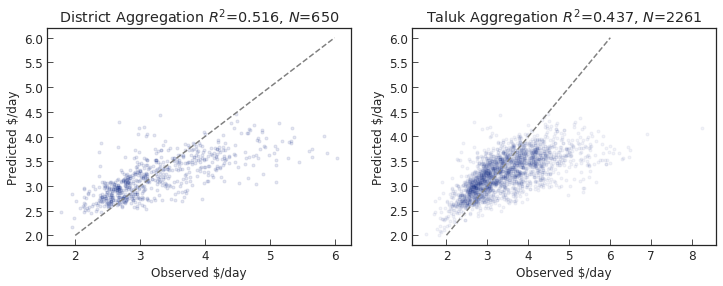

In [290]:
plot_scatters(district_df, taluk_df)

In [248]:
state_shapes = shapefile.Reader("../data/india_shape_files/IND_adm1.shp").shapes()
state_polygons = [sgeom.shape(s.__geo_interface__) for s in state_shapes]

In [249]:
district_shapes = shapefile.Reader("../data/india_shape_files/IND_adm2").shapes()
district_polygons = [sgeom.shape(s.__geo_interface__) for s in district_shapes]

In [250]:
taluk_shapes = shapefile.Reader("../data/india_shape_files/IND_adm3").shapes()
taluk_polygons = [sgeom.shape(s.__geo_interface__) for s in taluk_shapes]

In [291]:
bins = jenks_breaks(np.r_[convert_units(taluk_df["smoothed"]), 
                          convert_units(taluk_df["true"])], nb_class=4)

In [293]:
def plot_true_vs_pred(df, polygons):

  heatmap_colors = sns.color_palette("hot", 5)[::-1]
  fig = plt.figure(figsize=(14, 8))
  preds = convert_units(df["smoothed"])
  trues = convert_units(df["true"])

  countries = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(preds - 1e-4, bins)
  for i, color in zip(df["idx"], colors):
    polygon = polygons[i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Predicted", fontweight="bold", fontsize=12)

  ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
  ax.add_feature(countries, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  ax.set_extent([67, 98, 7.5, 36])
  
  colors = np.digitize(trues - 1e-4, bins)
  for i, color in zip(df["idx"], colors):
    polygon = polygons[i]
    poly = PolygonPatch(polygon, facecolor=rgb2hex(heatmap_colors[color]),
                        edgecolor="black")
    ax.add_patch(poly)
  plt.bar((-1), (-1), color=heatmap_colors[0], label="< %.2f" % bins[0])
  plt.bar((-1), (-1), color=heatmap_colors[1], label="%.2f - %.2f" % (bins[0], bins[1]))
  plt.bar((-1), (-1), color=heatmap_colors[2], label="%.2f - %.2f" % (bins[1], bins[2]))
  plt.bar((-1), (-1), color=heatmap_colors[3], label="%.2f - %.2f" % (bins[2], bins[3]))
  plt.bar((-1), (-1), color=heatmap_colors[4], label="> %.2f" % bins[3])
  ax.legend()
  plt.title("Actual", fontweight="bold", fontsize=12)

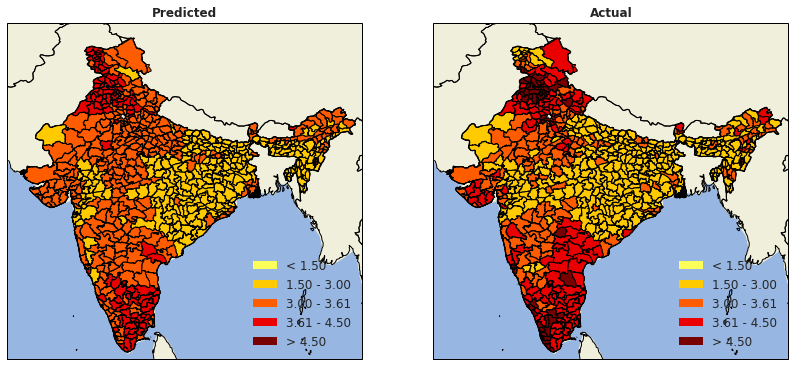

In [294]:
plot_true_vs_pred(district_df, district_polygons)

In [295]:
def plot_fold_boundaries(india_df): 
  plt.figure(figsize=(6, 8))
  ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
  ax.set_extent([67, 99, 7.5, 36])
  states_provinces = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')
  for i, polygon in enumerate(state_polygons):
    if i in set(india_df["state_idx"]):
      poly = PolygonPatch(polygon, facecolor="#607D8B", edgecolor="black")
      ax.add_patch(poly)
  ax.add_feature(states_provinces, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)
  plt.legend()

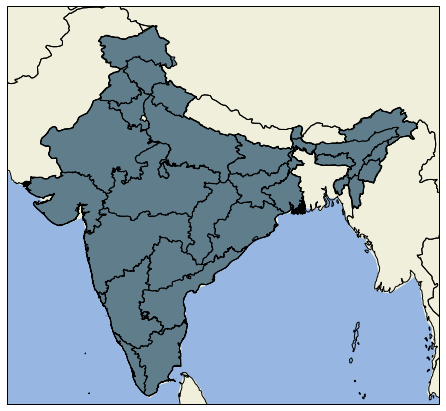

In [296]:
plot_fold_boundaries(india_df)

In [297]:
def plot_diffs(df, polygons):
  
  plt.figure(figsize=(6, 8))
  
  ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
  ax.set_extent([67, 99, 7.5, 36])

  states_provinces = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='50m',
      facecolor='none')

  cmap = plt.cm.hot
  values = np.abs(convert_units(df["smoothed"]) - convert_units(df["true"]))
  vmin = np.min(values)
  vmax = np.max(values)

  for idx, v in zip(df["idx"], values):
    color = rgb2hex(cmap(1-np.sqrt((v-vmin)/(vmax-vmin))))
    polygon = polygons[idx]
    poly = PolygonPatch(polygon, facecolor=color, edgecolor="black")
    ax.add_patch(poly)

  ax.add_feature(states_provinces, edgecolor="black")
  ax.add_feature(cfeature.OCEAN, zorder=0)
  ax.add_feature(cfeature.LAND, zorder=0)

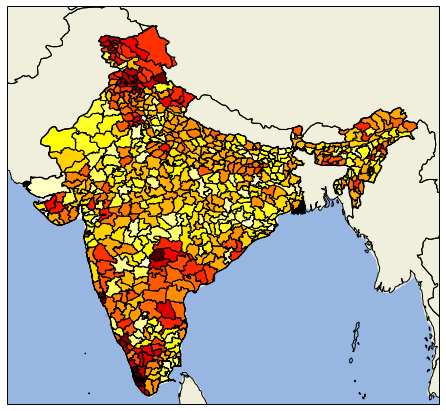

In [298]:
plot_diffs(district_df, district_polygons)

In [118]:
def plot_imagery_sample(india_processed, row_no=9888):
  row = india_processed.iloc[row_no,]
  plt.figure(figsize=(6, 3))
  ax = plt.subplot(1,2,1)
  img = Image.open("../../imagery/" + row["l8_path"])
  plt.imshow(img.crop((200, 200, 300, 300)).resize((100, 100)))
  ax.set_xticklabels(())
  ax.set_yticklabels(())
  ax = plt.subplot(1,2,2)
  img = Image.open("../../imagery/" + row["s1_path"])
  plt.imshow(img.crop((100, 100, 400, 400)).resize((100, 100)))
  ax.set_xticklabels(())
  ax.set_yticklabels(());

In [119]:
india_processed = pd.read_csv("../data/india_processed.csv")

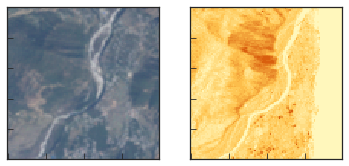

In [120]:
plot_imagery_sample(india_processed)